In [58]:
import pandas as pd
from pathlib import Path
from matplotlib import pyplot as plt
import numpy as np

In [59]:
station=["01_Rulo",
        "02_St_Joseph",
        "03_Kansas_City",
        "04_Waverly",
        "05_Boonville",
        "06_Hermann",
        "07_St_Charles",
        "08_Grafton",
        "09_ST_Louis",
        "10_Chester",
        "11_Thebes"]
USGS_id=["01_Rulo_06813500.csv",
        "02_St_Joseph_06818000.csv",
        "03_Kansas_City_06893000.csv",
        "04_Waverly_06895500.csv",
        "05_Boonville_06909000.csv",
        "06_Hermann_06934500.csv",
        "07_St_Charles_06935965.csv",
        "08_Grafton_05587450.csv",
        "09_ST_Louis_07010000.csv",
        "10_Chester_07020500.csv",
        "11_Thebes_07022000.csv"]
         
i=10

In [60]:
base = Path(f"/media/12TB/Sujan/NWM/Csv/{station[i]}/All")

df_USGS = pd.read_csv(f"/media/12TB/Sujan/NWM/USGS_data/{USGS_id[i]}",
                      parse_dates=["timestamp"]).set_index("timestamp")

# df_USGS["discharge_cumecs"] = df_USGS["discharge_cfs"] / 35.3147

In [61]:
def find_GH_with_tolerance(
    df_nwm,
    df_usgs,
    day_skip=7,
    day_bracket=7,
    q_tolerance=1.0,
    nwm_col="streamflow",
    usgs_q_col="discharge_cumecs",
    usgs_h_col="stage_ft",
):
    """
    For each NWM time t (after day_skip), search USGS data within [t - day_bracket, t + day_bracket].
    Take the mean of all USGS stages whose discharge lies within ±q_tolerance of the NWM discharge.
    If none match, return NaN. No interpolation.

    Parameters
    ----------
    df_nwm : DataFrame with DatetimeIndex and column nwm_col (default 'streamflow')
    df_usgs : DataFrame with DatetimeIndex and columns usgs_q_col ('discharge_cumecs'),
              usgs_h_col ('stage_ft')
    day_skip : days to skip from the start of df_nwm before processing
    day_bracket : half-window in days around each NWM time
    q_tolerance : discharge tolerance (same units as df_usgs[usgs_q_col])
    nwm_col, usgs_q_col, usgs_h_col : column names for flexibility
    """
    if not isinstance(df_nwm.index, pd.DatetimeIndex):
        raise TypeError("df_nwm must have a DatetimeIndex")
    if not isinstance(df_usgs.index, pd.DatetimeIndex):
        raise TypeError("df_usgs must have a DatetimeIndex")
    for col in [nwm_col]:
        if col not in df_nwm.columns:
            raise KeyError(f"df_nwm needs '{nwm_col}' column")
    for col in [usgs_q_col, usgs_h_col]:
        if col not in df_usgs.columns:
            raise KeyError(f"df_usgs needs '{usgs_q_col}' and '{usgs_h_col}' columns")

    # Keep needed cols and drop NaNs on USGS side
    nwm = df_nwm[[nwm_col]].copy()
    usgs = df_usgs[[usgs_q_col, usgs_h_col]].dropna().copy()

    # Sort by time for fast time-slicing
    nwm.sort_index(inplace=True)
    usgs.sort_index(inplace=True)

    # Apply day_skip
    start_time = nwm.index.min() + pd.Timedelta(days=day_skip)
    nwm_use = nwm.loc[nwm.index >= start_time].copy()

    out_records = []
    halfwin = pd.Timedelta(days=day_bracket)

    for t, row in nwm_use.iterrows():
        q = row[nwm_col]
        if pd.isna(q):
            out_records.append((t, np.nan))
            continue

        # Time window
        us = usgs.loc[t - halfwin : t + halfwin]
        if us.empty:
            out_records.append((t, np.nan))
            continue

        # Discharge band ± q_tolerance
        band = us[(us[usgs_q_col] >= q - q_tolerance) & (us[usgs_q_col] <= q + q_tolerance)]
        if band.empty:
            out_records.append((t, np.nan))
            continue

        gh_mean = float(band[usgs_h_col].mean())
        out_records.append((t, gh_mean))

    result = nwm.copy()
    gh_series = pd.DataFrame(out_records, columns=["time", "Computed_GH_m"]).set_index("time")
    result = result.join(gh_series, how="left")
    return result

def run_one(file_path, df_usgs, code,
            day_skip=0, day_bracket=10, q_tolerance=5.0):
    df_nwm = pd.read_csv(file_path, parse_dates=["time"]).set_index("time")
    out = find_GH_with_tolerance(
        df_nwm, df_usgs,
        day_skip=day_skip,
        day_bracket=day_bracket,
        q_tolerance=q_tolerance,
        nwm_col="streamflow",
        usgs_q_col="discharge_cumecs",
        usgs_h_col="stage_m"
    )

    fill = out["Computed_GH_m"].notna().mean()
    print(f"{code}: filled {fill:.1%}  "
          f"window=±{day_bracket}d, Q_tol={q_tolerance})_")
    return out["Computed_GH_m"].rename(code)

In [62]:
day_bracket = 90  # days on either side of NWM time
day_skip = 30
q_tol_step  = 0.01
q_tolerance = 10.0
q_tol_max = None

wide = None
for idx, h in enumerate(range(6, 721, 6)):  # 006..720
    code = f"{h:03d}"
    f = base / f"timeseries_{code}.csv"
    if not f.exists():
        continue

    q_tol = q_tolerance + idx * q_tol_step
    if q_tol_max is not None:
        q_tol = min(q_tol, q_tol_max)

    s = run_one(f, df_USGS, code, day_skip, day_bracket, q_tol)

    if wide is None:
        wide = pd.DataFrame(index=s.index)
    wide = wide.join(s, how="outer")

# If nothing loaded, bail early
if wide is None:
    raise RuntimeError("No timeseries_* files were found or produced output.")

wide.sort_index(inplace=True)

# 2) Bring USGS stage onto the NWM union index via nearest-time match
# Using merge_asof for robust nearest alignment (set a tolerance you trust)
usgs_stage = (
    pd.merge_asof(
        left=wide.reset_index().rename(columns={"index":"time"}).sort_values("time"),
        right=df_USGS[["stage_m"]].reset_index().rename(columns={"timestamp":"time"}).sort_values("time"),
        on="time", direction="nearest", tolerance=pd.Timedelta("3H")  # adjust tolerance as needed
    )
    .set_index("time")["stage_m"]
    .rename("stage_m_USGS_nearest")
)

# 3) Combine
merged_all = wide.join(usgs_stage, how="left")

merged_all.to_csv(f"/media/12TB/Sujan/NWM/Codes/LRF_RC/NWM_Q_to_GH/{station[i]}_q_tolerance_{q_tolerance}_day_bracket_{day_bracket}.csv")

006: filled 71.6%  window=±90d, Q_tol=10.0)_
012: filled 73.2%  window=±90d, Q_tol=10.01)_
018: filled 72.1%  window=±90d, Q_tol=10.02)_
024: filled 71.8%  window=±90d, Q_tol=10.03)_
030: filled 71.5%  window=±90d, Q_tol=10.04)_
036: filled 71.8%  window=±90d, Q_tol=10.05)_
042: filled 71.2%  window=±90d, Q_tol=10.06)_
048: filled 71.4%  window=±90d, Q_tol=10.07)_
054: filled 70.5%  window=±90d, Q_tol=10.08)_
060: filled 70.2%  window=±90d, Q_tol=10.09)_
066: filled 71.5%  window=±90d, Q_tol=10.1)_
072: filled 70.9%  window=±90d, Q_tol=10.11)_
078: filled 71.8%  window=±90d, Q_tol=10.12)_
084: filled 70.4%  window=±90d, Q_tol=10.13)_
090: filled 71.3%  window=±90d, Q_tol=10.14)_
096: filled 70.6%  window=±90d, Q_tol=10.15)_
102: filled 70.3%  window=±90d, Q_tol=10.16)_
108: filled 70.2%  window=±90d, Q_tol=10.17)_
114: filled 70.5%  window=±90d, Q_tol=10.18)_
120: filled 70.1%  window=±90d, Q_tol=10.19)_
126: filled 70.1%  window=±90d, Q_tol=10.2)_
132: filled 70.1%  window=±90d, Q_tol

/tmp/ipykernel_456105/2761394802.py:36: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  on="time", direction="nearest", tolerance=pd.Timedelta("3H")  # adjust tolerance as needed


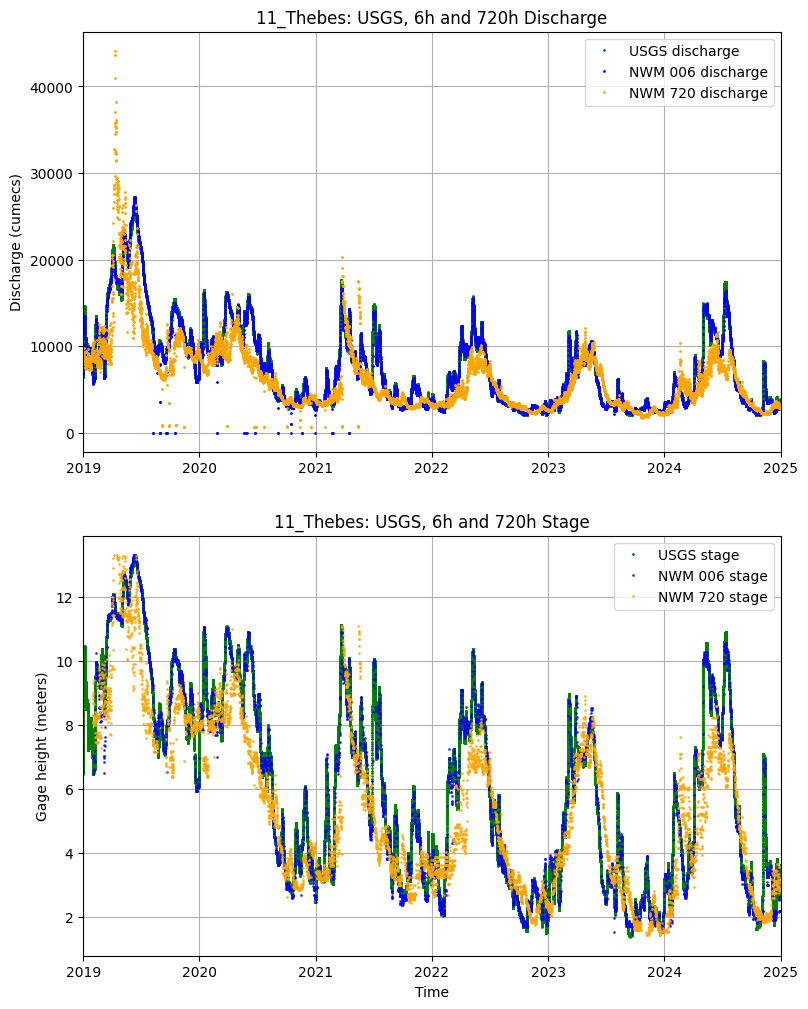

In [63]:
hrs1="006"
hrs2="720"
t0 = "2019-01-01"
t1 = "2025-01-01"

df_hrs1_NWM= pd.read_csv(f"/media/12TB/Sujan/NWM/Csv/{station[i]}/All/timeseries_{hrs1}.csv", parse_dates=["time"]).set_index("time")
df_hrs2_NWM= pd.read_csv(f"/media/12TB/Sujan/NWM/Csv/{station[i]}/All/timeseries_{hrs2}.csv", parse_dates=["time"]).set_index("time")

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(9, 12))
ax1.plot(df_USGS.index, df_USGS["discharge_cumecs"],"o",  label="USGS discharge", color='green', markersize=1)
ax1.plot(df_hrs1_NWM.index, df_hrs1_NWM["streamflow"],"o", label=f"NWM {hrs1} discharge", color='blue', markersize=1)
ax1.plot(df_hrs2_NWM.index, df_hrs2_NWM["streamflow"],"o", label=f"NWM {hrs2} discharge", color='orange', markersize=1)

ax2.plot(df_USGS.index, df_USGS["stage_m"],"o",  label="USGS stage", color='green', markersize=1)
ax2.plot(merged_all.index, merged_all.get(hrs1), "o", label=f"NWM {hrs1} stage", alpha=0.7, color='blue', markersize=1)
ax2.plot(merged_all.index, merged_all.get(hrs2),"o", label=f"NWM {hrs2} stage", alpha=0.7, color='orange', markersize=1)

ax1.set_ylabel("Discharge (cumecs)")
ax1.set_title(f"{station[i]}: USGS, 6h and 720h Discharge")
ax1.legend()
ax1.grid()  
ax1.set_xlim(pd.to_datetime(t0), pd.to_datetime(t1))

ax2.set_xlabel("Time")
ax2.set_xlim(pd.to_datetime(t0), pd.to_datetime(t1))
ax2.set_ylabel("Gage height (meters)")
ax2.set_title(f"{station[i]}: USGS, 6h and 720h Stage")
ax2.legend()
ax2.grid()
fig.savefig(f"/media/12TB/Sujan/NWM/Codes/LRF_RC/NWM_Q_to_GH/{station[i]}_q_tolerance_{q_tolerance}_day_bracket_{day_bracket}.png", dpi=300)


In [68]:
import pandas as pd
import numpy as np
import re
from pathlib import Path

# ----------------------------
# Metrics
# ----------------------------
def mae(y_true, y_pred):
    y_true, y_pred = np.asarray(y_true), np.asarray(y_pred)
    return np.mean(np.abs(y_pred - y_true))

def mse(y_true, y_pred):
    y_true, y_pred = np.asarray(y_true), np.asarray(y_pred)
    return np.mean((y_pred - y_true) ** 2)

def kge(y_true, y_pred):
    """
    Kling-Gupta Efficiency (Gupta et al., 2009), using:
    r = Pearson correlation
    alpha = std(pred)/std(true)
    beta = mean(pred)/mean(true)
    KGE = 1 - sqrt((r-1)^2 + (alpha-1)^2 + (beta-1)^2)
    """
    y_true, y_pred = np.asarray(y_true), np.asarray(y_pred)
    if y_true.size < 2:
        return np.nan
    r = np.corrcoef(y_true, y_pred)[0, 1]
    if np.isnan(r):
        return np.nan
    std_t = np.std(y_true, ddof=1)
    std_p = np.std(y_pred, ddof=1)
    mean_t = np.mean(y_true)
    mean_p = np.mean(y_pred)
    if std_t == 0 or mean_t == 0:
        return np.nan
    alpha = std_p / std_t
    beta = mean_p / mean_t
    return 1.0 - np.sqrt((r - 1.0) ** 2 + (alpha - 1.0) ** 2 + (beta - 1.0) ** 2)

def nse(y_true, y_pred):
    """
    Nash–Sutcliffe Efficiency.
    """
    y_true, y_pred = np.asarray(y_true), np.asarray(y_pred)
    if y_true.size == 0:
        return np.nan
    denom = np.sum((y_true - np.mean(y_true)) ** 2)
    if denom == 0:
        return np.nan
    return 1.0 - np.sum((y_pred - y_true) ** 2) / denom

# ----------------------------
# Helper: compute metrics for one file
# ----------------------------
def summarize_file(file_path):
    """
    Returns a single-row DataFrame with columns like:
    006_MAE, 006_MSE, 006_KGE, 006_NSE, 012_MAE, ...
    """
    df = pd.read_csv(file_path, parse_dates=["time"]) if "time" in open(file_path).read(200).lower() else pd.read_csv(file_path)
    # Try to set index to time if present
    if "time" in df.columns:
        df = df.set_index("time")
    if "stage_m_USGS_nearest" not in df.columns:
        raise KeyError(f"'stage_m_USGS_nearest' not found in {file_path}")

    y = df["stage_m_USGS_nearest"]

    # horizon columns are 3-digit strings
    horizons = [c for c in df.columns if re.fullmatch(r"\d{3}", str(c))]
    if not horizons:
        raise ValueError(f"No horizon columns like '006' found in {file_path}")

    out = {}
    for h in sorted(horizons, key=lambda s: int(s)):
        pair = pd.concat([y, df[h]], axis=1, keys=["obs", "sim"]).dropna()
        if pair.empty:
            out[f"{h}_MAE"] = np.nan
            out[f"{h}_MSE"] = np.nan
            out[f"{h}_KGE"] = np.nan
            out[f"{h}_NSE"] = np.nan
            out[f"{h}_N"]   = 0
            continue
        yt = pair["obs"].values
        yp = pair["sim"].values
        out[f"{h}_MAE"] = mae(yt, yp)
        out[f"{h}_MSE"] = mse(yt, yp)
        out[f"{h}_KGE"] = kge(yt, yp)
        out[f"{h}_NSE"] = nse(yt, yp)
        out[f"{h}_N"]   = len(pair)

    # Also include some file-level info if useful
    sr = pd.Series(out)
    return sr.to_frame().T  # single row

# ----------------------------
# Batch over your 10 station files
# ----------------------------
station_files = [
    "/media/12TB/Sujan/NWM/Codes/LRF_RC/NWM_Q_to_GH/01_Rulo_q_tolerance_10.0_day_bracket_90.csv",
    "/media/12TB/Sujan/NWM/Codes/LRF_RC/NWM_Q_to_GH/02_St_Joseph_q_tolerance_5.0_day_bracket_90.csv",
    "/media/12TB/Sujan/NWM/Codes/LRF_RC/NWM_Q_to_GH/03_Kansas_City_q_tolerance_5.0_day_bracket_90.csv",
    "/media/12TB/Sujan/NWM/Codes/LRF_RC/NWM_Q_to_GH/04_Waverly_q_tolerance_5.0_day_bracket_90.csv",
    "/media/12TB/Sujan/NWM/Codes/LRF_RC/NWM_Q_to_GH/05_Boonville_q_tolerance_10.0_day_bracket_90.csv",
    "/media/12TB/Sujan/NWM/Codes/LRF_RC/NWM_Q_to_GH/06_Hermann_q_tolerance_10.0_day_bracket_90.csv",
    "/media/12TB/Sujan/NWM/Codes/LRF_RC/NWM_Q_to_GH/07_St_Charles_q_tolerance_10.0_day_bracket_90.csv",
    "/media/12TB/Sujan/NWM/Codes/LRF_RC/NWM_Q_to_GH/08_Grafton_q_tolerance_10.0_day_bracket_90.csv",
    "/media/12TB/Sujan/NWM/Codes/LRF_RC/NWM_Q_to_GH/09_ST_Louis_q_tolerance_10.0_day_bracket_90.csv",
    "/media/12TB/Sujan/NWM/Codes/LRF_RC/NWM_Q_to_GH/10_Chester_q_tolerance_10.0_day_bracket_90.csv",
    "/media/12TB/Sujan/NWM/Codes/LRF_RC/NWM_Q_to_GH/11_Thebes_q_tolerance_10.0_day_bracket_90.csv"
]

summary_rows = []
index_labels = []

for fp in station_files:
    name = Path(fp).stem  
    try:
        row = summarize_file(fp)
        row.index = [name]  # label the row with the station file stem
        summary_rows.append(row)
        index_labels.append(name)
        print(f"OK: {name}")
    except Exception as e:
        print(f"Failed: {name} -> {e}")

summary_df = pd.concat(summary_rows, axis=0).sort_index()

# Optional: save
summary_df.to_csv("/media/12TB/Sujan/NWM/Codes/LRF_RC/NWM_Q_to_GH/summary_metrics.csv")

summary_df.head()


OK: 01_Rulo_q_tolerance_10.0_day_bracket_90
OK: 02_St_Joseph_q_tolerance_5.0_day_bracket_90
OK: 03_Kansas_City_q_tolerance_5.0_day_bracket_90
OK: 04_Waverly_q_tolerance_5.0_day_bracket_90
OK: 05_Boonville_q_tolerance_10.0_day_bracket_90
OK: 06_Hermann_q_tolerance_10.0_day_bracket_90
OK: 07_St_Charles_q_tolerance_10.0_day_bracket_90
OK: 08_Grafton_q_tolerance_10.0_day_bracket_90
OK: 09_ST_Louis_q_tolerance_10.0_day_bracket_90
OK: 10_Chester_q_tolerance_10.0_day_bracket_90
OK: 11_Thebes_q_tolerance_10.0_day_bracket_90


,006_MAE,006_MSE,006_KGE,006_NSE,006_N,012_MAE,012_MSE,012_KGE,012_NSE,012_N,...,714_MAE,714_MSE,714_KGE,714_NSE,714_N,720_MAE,720_MSE,720_KGE,720_NSE,720_N
01_Rulo_q_tolerance_10.0_day_bracket_90,0.080459,0.023366,0.993595,0.990211,8698.0,0.118243,0.047736,0.985457,0.979597,8643.0,...,0.660875,0.819116,0.772456,0.564769,6324.0,0.661245,0.818859,0.773264,0.568257,6333.0
02_St_Joseph_q_tolerance_5.0_day_bracket_90,0.088534,0.031782,0.989586,0.983708,8204.0,0.128465,0.059869,0.982546,0.969531,8168.0,...,0.677433,0.859370,0.698476,0.484375,6302.0,0.677625,0.862065,0.701795,0.492490,6305.0
03_Kansas_City_q_tolerance_5.0_day_bracket_90,0.097074,0.028111,0.993078,0.987247,7993.0,0.145496,0.063172,0.983842,0.971746,8047.0,...,0.744085,1.046267,0.655822,0.492140,6326.0,0.741456,1.033978,0.662057,0.511691,6314.0
04_Waverly_q_tolerance_5.0_day_bracket_90,0.081633,0.023075,0.986103,0.986180,7924.0,0.098541,0.036295,0.985016,0.977394,7890.0,...,0.656866,0.839617,0.632779,0.472958,6371.0,0.659595,0.849824,0.626407,0.467621,6362.0
05_Boonville_q_tolerance_10.0_day_bracket_90,0.175051,0.092206,0.982266,0.970703,8281.0,0.190074,0.109566,0.978332,0.965276,8277.0,...,0.842089,1.496431,0.670629,0.483518,7420.0,0.845369,1.499589,0.675350,0.486485,7414.0


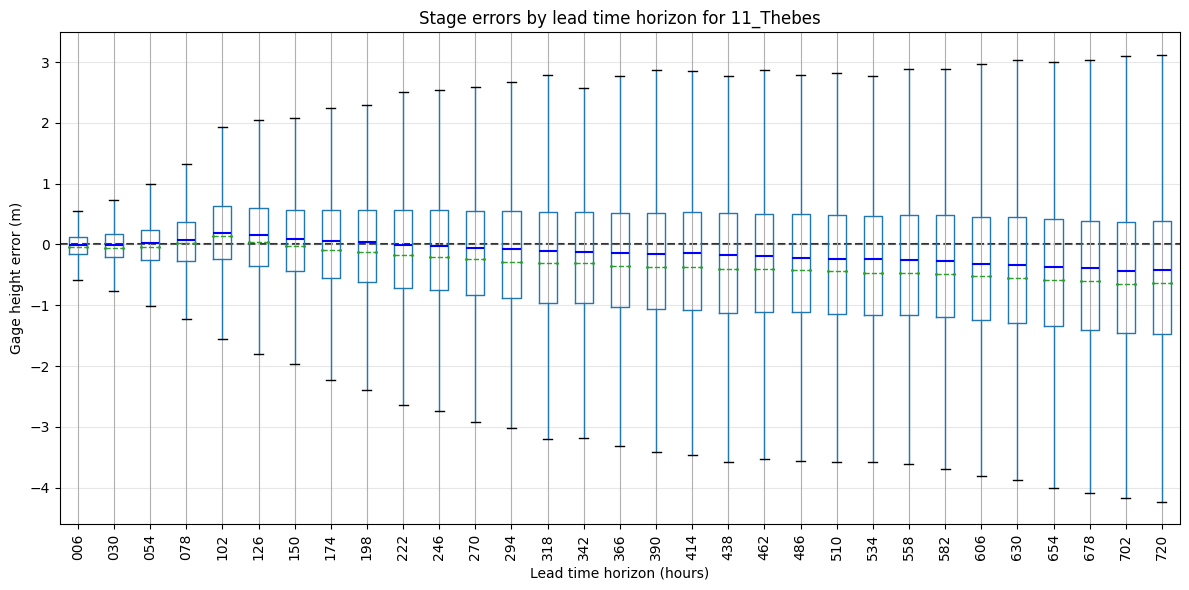

In [67]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load your file (as you already do)
stationfile=i
fp = station_files[stationfile]
df = pd.read_csv(fp, parse_dates=["time"]).set_index("time")

# Build the error matrix (sim - obs) only for selected horizons
obs_col = "stage_m_USGS_nearest"
all_horizons = [c for c in df.columns if re.fullmatch(r"\d{3}", str(c))]

# Horizons every 24h starting at 006: 006, 030, 054, ...
jumped = [f"{h:03d}" for h in range(6, 721, 24)]
# Optionally force-include 720 if it exists
if "720" in all_horizons and "720" not in jumped:
    jumped.append("720")

# Keep only those that actually exist in the file
cols = [c for c in jumped if c in all_horizons]

# Construct error dataframe
err_df = pd.concat(
    [(df[c] - df[obs_col]).rename(c) for c in cols],
    axis=1
).dropna(how="all")

# Optional: remove rows where a given column is NaN when plotting each box
# (boxplot will ignore NaNs per column, so this is usually not necessary)

# Plot
fig, ax = plt.subplots(figsize=(12, 6))
err_df.boxplot(
    column=err_df.columns.tolist(),
    ax=ax,
    showfliers=False,
    showmeans=True,     # show mean marker
    meanline=True,      # draw mean as a line across the box
    meanprops={"marker": "D", "markersize": 1},  # diamond marker
    medianprops={"linewidth": 1.5, "color": "blue"},
)   # set True to show outliers

# Highlight y=0
ax.axhline(0, linestyle="--", linewidth=1.5, color="k", alpha=0.8, zorder=0)

# Cosmetics
ax.set_xlabel("Lead time horizon (hours)")
ax.set_ylabel("Gage height error (m)")
ax.set_title("Stage errors by lead time horizon for "+station[stationfile])
ax.set_xticklabels(cols, rotation=90)
ax.grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.show()
